In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50, VGG19

In [4]:
# Allow GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [5]:
# Function to get images and labels from the dataset directory
def create_image_dataframe(dataset_dir):
    image_paths = []
    labels = []
    heights = []
    widths = []
    channels = []

    # Traverse through all the subdirectories (class folders)
    for folder_name in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder_name)
        
        if os.path.isdir(folder_path):  # If it's a folder
            # Get all image files in the folder
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                
                # Check if it's an image file (you can add more file types if needed)
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(image_path)
                    labels.append(folder_name)  # The label is the folder name
                    
                    # Read image to get dimensions
                    img = cv2.imread(image_path)
                    height, width, channel = img.shape
                    heights.append(height)
                    widths.append(width)
                    channels.append(channel)

    # Create a DataFrame with image paths, labels, and dimensions
    data = {'image_path': image_paths, 'label': labels, 'height': heights, 'width': widths, 'channels': channels}
    df = pd.DataFrame(data)

    return df

In [6]:
dataset_dir = r'C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION\DATASET\Create'
df = create_image_dataframe(dataset_dir)

In [7]:
df.head()

,image_path,label,height,width,channels
0,C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION...,baby_back_ribs,512,512,3
1,C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION...,baby_back_ribs,384,512,3
2,C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION...,baby_back_ribs,512,512,3
3,C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION...,baby_back_ribs,512,384,3
4,C:\Users\abhip\Music\AI NUTRITION\AI NUTRITION...,baby_back_ribs,512,512,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  4000 non-null   object
 1   label       4000 non-null   object
 2   height      4000 non-null   int64 
 3   width       4000 non-null   int64 
 4   channels    4000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 156.4+ KB


In [9]:
df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=200, random_state=42))


C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\2778187121.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=200, random_state=42))


In [10]:
df['label'].value_counts()

label
baby_back_ribs    200
chicken_wings     200
chocolate_cake    200
frozen_yogurt     200
Name: count, dtype: int64

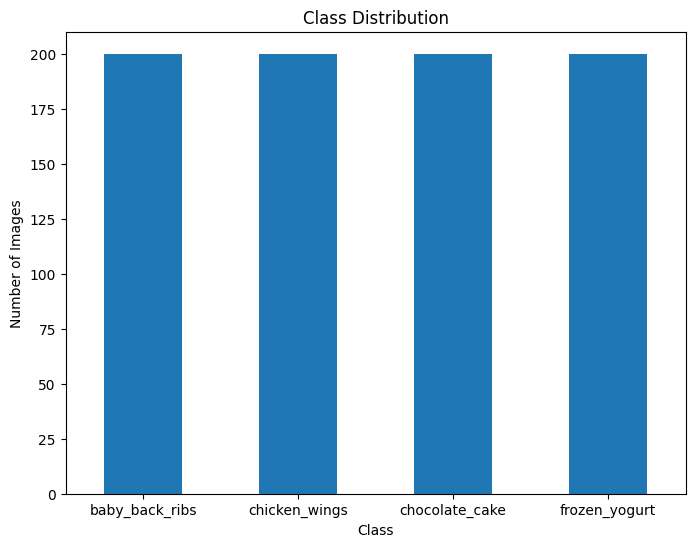

In [11]:
# Plot class distribution (diabetic vs normal)
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

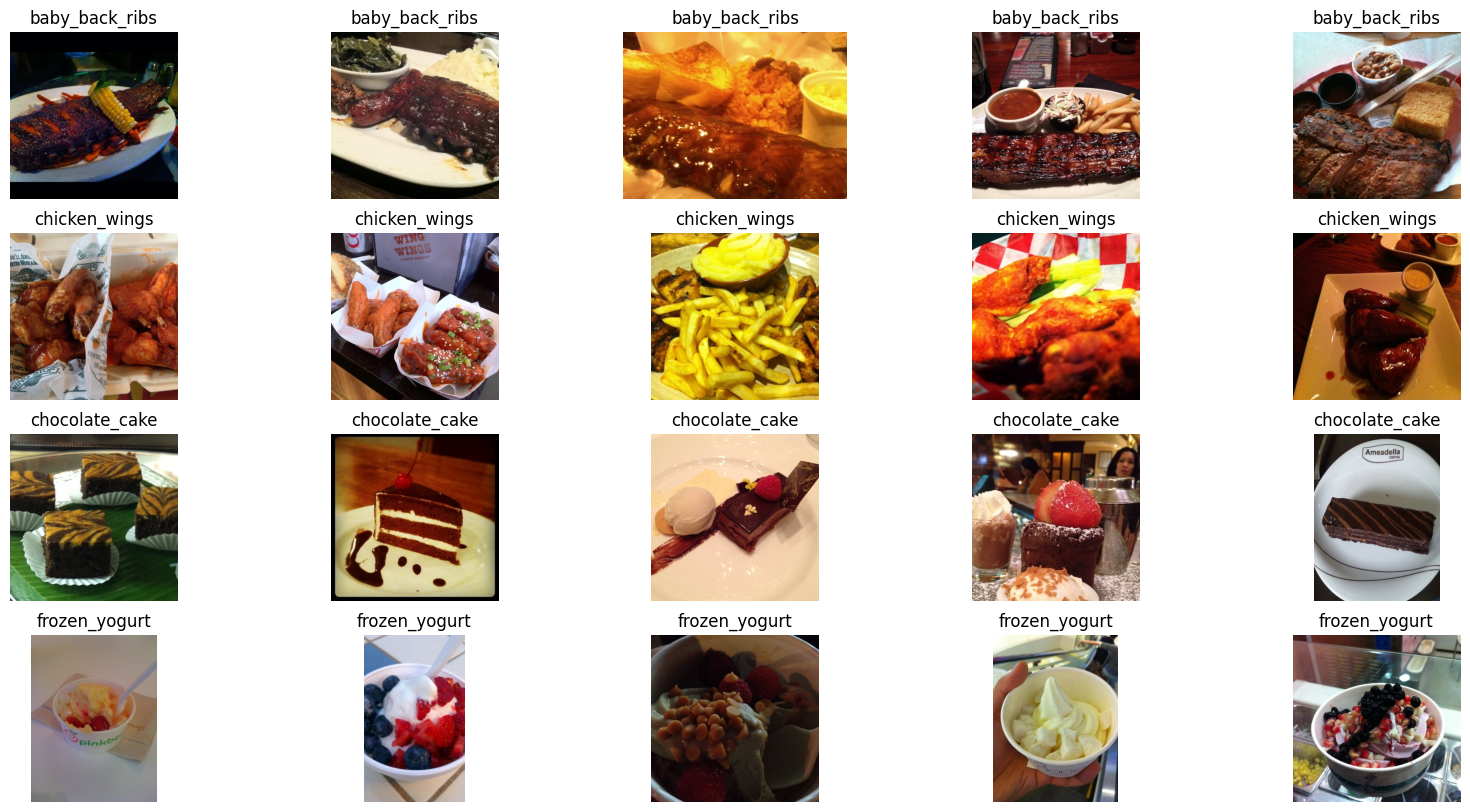

In [12]:
# Function to show 5 images from each class (diabetic and normal)
def show_images_by_class(df, num_samples=5):
    # Get 5 samples from each class
    baby_back_ribs_df = df[df['label'] == 'baby_back_ribs'].sample(n=num_samples, random_state=42)
    chicken_wings_df = df[df['label'] == 'chicken_wings'].sample(n=num_samples, random_state=42)
    chocolate_cake_df = df[df['label'] == 'chocolate_cake'].sample(n=num_samples, random_state=42)
    frozen_yogurt_df = df[df['label'] == 'frozen_yogurt'].sample(n=num_samples, random_state=42)

    fig, axes = plt.subplots(4, num_samples, figsize=(20, 10))

    # Show 5 images
    for i in range(num_samples):
        img_path = baby_back_ribs_df.iloc[i]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[0, i].imshow(img)
        axes[0, i].set_title("baby_back_ribs")
        axes[0, i].axis('off')  # Hide axes for better visualization

    for i in range(num_samples):
        img_path = chicken_wings_df.iloc[i]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[1, i].imshow(img)
        axes[1, i].set_title("chicken_wings")
        axes[1, i].axis('off')  # Hide axes for better visualization

    for i in range(num_samples):
        img_path = chocolate_cake_df.iloc[i]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[2, i].imshow(img)
        axes[2, i].set_title("chocolate_cake")
        axes[2, i].axis('off')  # Hide axes for better visualization

    for i in range(num_samples):
        img_path = frozen_yogurt_df.iloc[i]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[3, i].imshow(img)
        axes[3, i].set_title("frozen_yogurt")
        axes[3, i].axis('off')  # Hide axes for better visualization
        
    plt.show()

# Display 5 images from each class
show_images_by_class(df)

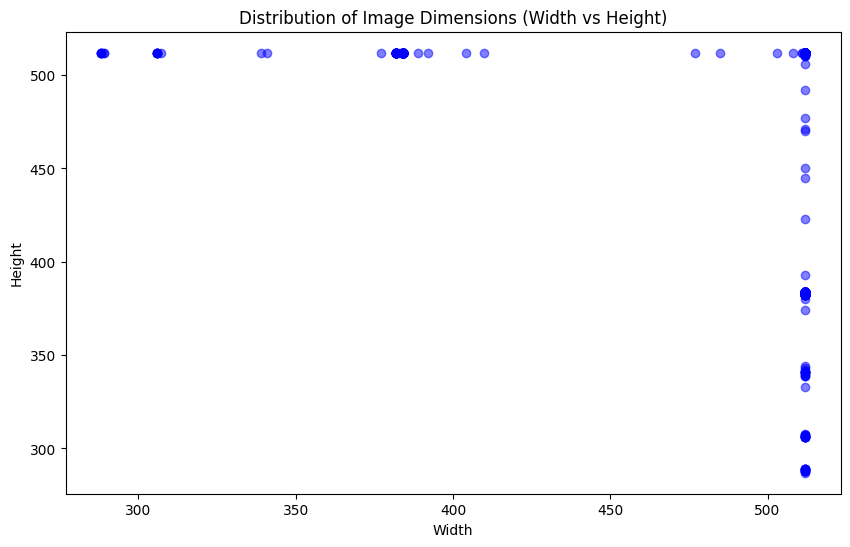

In [13]:
# Plot the distribution of image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(df['width'], df['height'], alpha=0.5, color='blue')
plt.title('Distribution of Image Dimensions (Width vs Height)')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

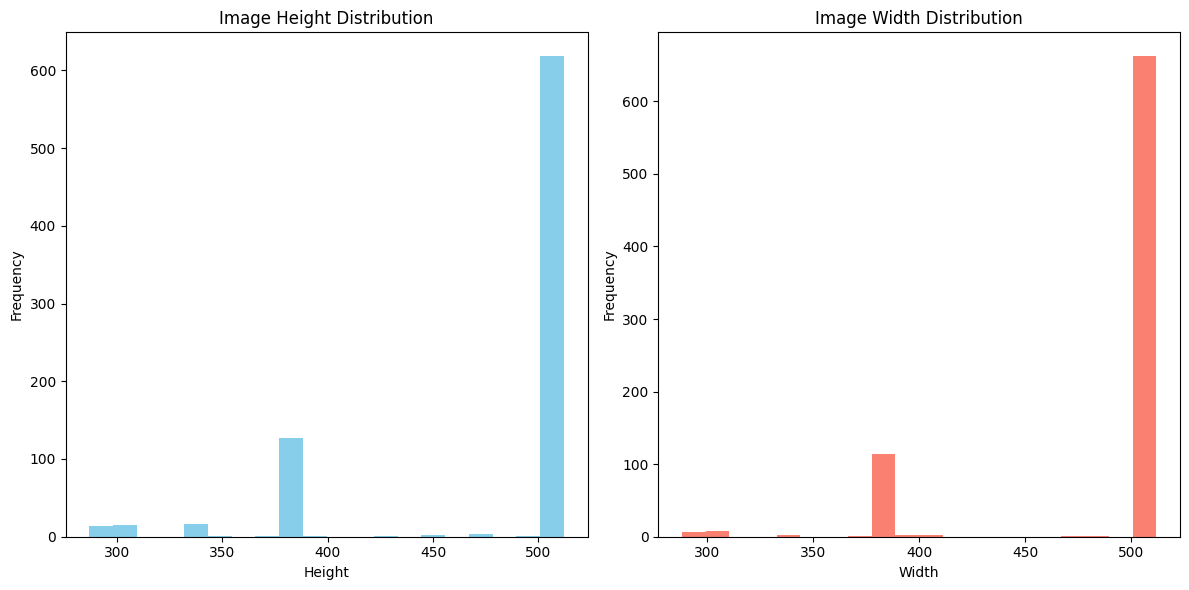

In [14]:
# Plot the distribution of image dimensions (width and height)
plt.figure(figsize=(12, 6))

# Plot image height distribution
plt.subplot(1, 2, 1)
plt.hist(df['height'], bins=20, color='skyblue')
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Plot image width distribution
plt.subplot(1, 2, 2)
plt.hist(df['width'], bins=20, color='salmon')
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

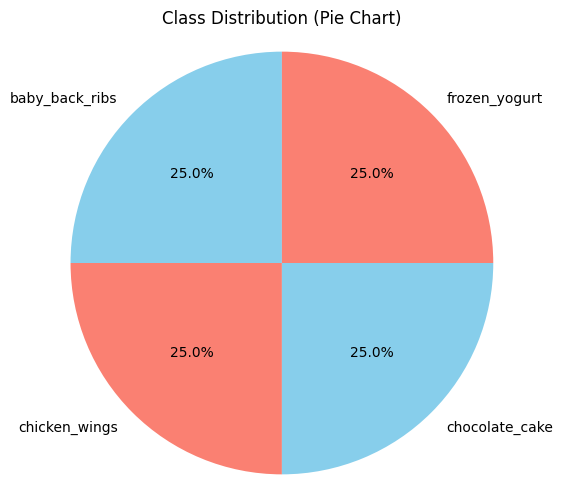

In [15]:
# Pie chart for class distribution
class_counts = df['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title('Class Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

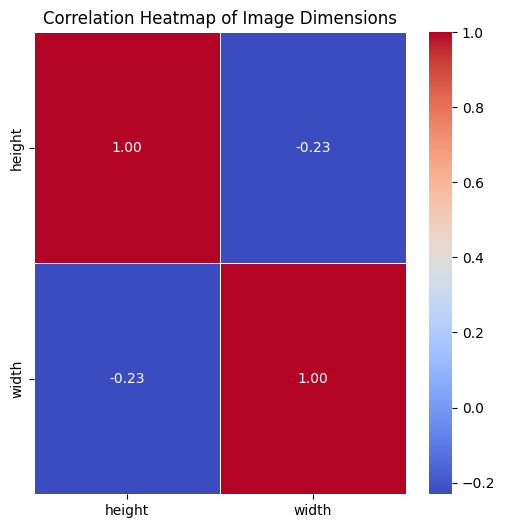

In [16]:
# Correlation heatmap for image dimensions
corr = df[['height', 'width']].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Image Dimensions')
plt.show()

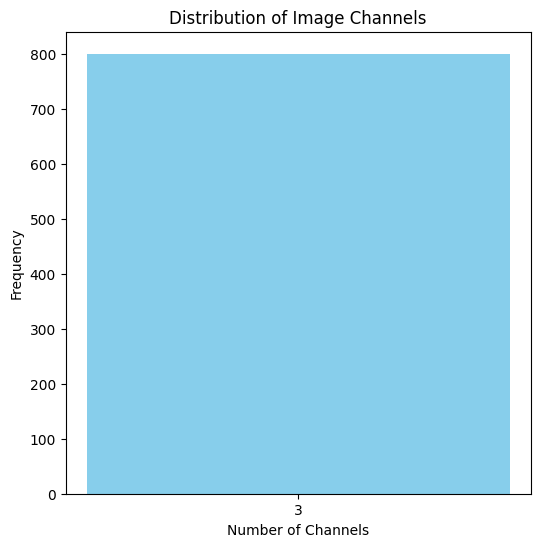

In [17]:
# Histogram of image channels
num_channels = df['channels'].value_counts()
plt.figure(figsize=(6, 6))
plt.bar(num_channels.index, num_channels.values, color=['skyblue', 'salmon'])
plt.title('Distribution of Image Channels')
plt.xlabel('Number of Channels')
plt.ylabel('Frequency')
plt.xticks(num_channels.index)
plt.show()


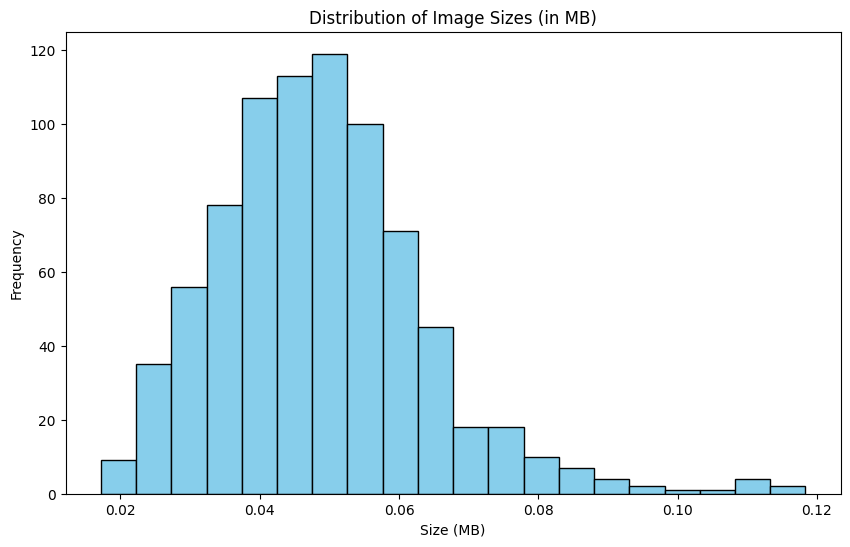

In [18]:
# Calculate image file sizes
image_sizes = [os.path.getsize(img_path) / (1024 * 1024) for img_path in df['image_path']]  # size in MB
size_df = pd.DataFrame(image_sizes, columns=['size_MB'])

# Histogram of image sizes
plt.figure(figsize=(10, 6))
plt.hist(size_df['size_MB'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Sizes (in MB)')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')
plt.show()


C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\1389803023.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='height', data=df, palette=['skyblue', 'salmon'])
C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\1389803023.py:6: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='label', y='height', data=df, palette=['skyblue', 'salmon'])
C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\1389803023.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='width', data=df, palette=['skyblue', 'salmon'])
C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\1389803023.py:11: UserWar

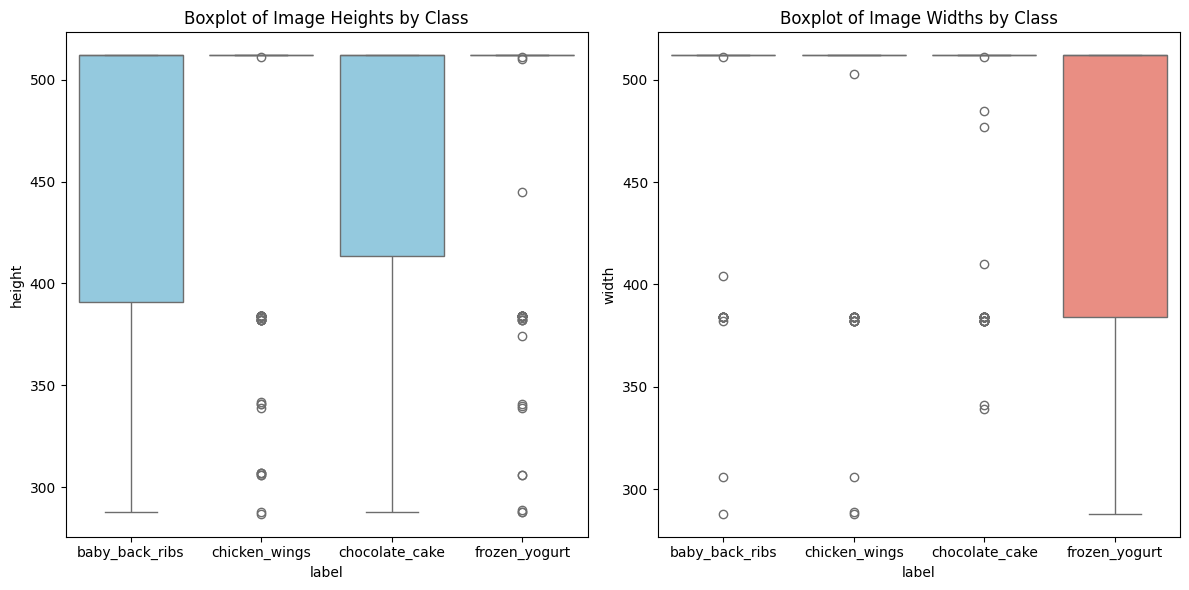

In [19]:
# Boxplot for image dimensions (height and width)
plt.figure(figsize=(12, 6))

# Boxplot for image height
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='height', data=df, palette=['skyblue', 'salmon'])
plt.title('Boxplot of Image Heights by Class')

# Boxplot for image width
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='width', data=df, palette=['skyblue', 'salmon'])
plt.title('Boxplot of Image Widths by Class')

plt.tight_layout()
plt.show()

C:\Users\abhip\AppData\Local\Temp\ipykernel_20596\4213115315.py:3: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='width', y='height', hue='label', data=df, palette=['skyblue', 'salmon'], alpha=0.6)


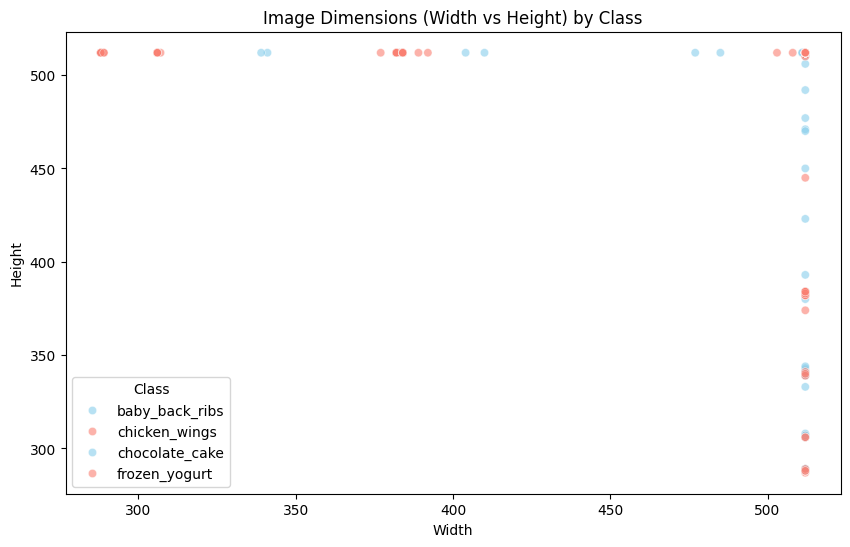

In [20]:
# Scatter plot for image dimensions (height vs width) colored by class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='width', y='height', hue='label', data=df, palette=['skyblue', 'salmon'], alpha=0.6)
plt.title('Image Dimensions (Width vs Height) by Class')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Class')
plt.show()


In [21]:
# Initialize label encoder
label_encoder = LabelEncoder()

In [22]:
# Fit and transform the labels
df['encoded_label'] = label_encoder.fit_transform(df['label'])

In [23]:
# Save the label encoder to a pickle file
with open('label_encodernew.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [24]:
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [25]:
# Function to load images and preprocess them
def load_images(df, img_size=(224, 224)):
    images = []
    labels = df['encoded_label'].values  # Encoded labels

    for img_path in df['image_path']:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)  # Resize to 224x224 for VGG16
        img = img / 255.0  # Normalize to range [0,1]
        images.append(img)

    return np.array(images), np.array(labels)


In [26]:
# Load images
X, y = load_images(df)

# One-hot encode labels
num_classes = len(df['label'].unique())
y = to_categorical(y, num_classes=num_classes)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Load pre-trained VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [28]:

# Freeze base model layers (optional, for feature extraction)
for layer in base_model.layers:
    layer.trainable = False



In [29]:
# Add custom classification layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])



In [30]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [31]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Define Image Augmentation
datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2, horizontal_flip=True)




In [33]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    verbose=1)

c:\Users\abhip\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 203s 10s/step - accuracy: 0.3173 - loss: 6.6425 - val_accuracy: 0.4500 - val_loss: 2.5227
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.5475 - loss: 2.0433 - val_accuracy: 0.6438 - val_loss: 0.8628
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.6938 - loss: 0.7465 - val_accuracy: 0.6875 - val_loss: 0.7275
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.7664 - loss: 0.5740 - val_accuracy: 0.7625 - val_loss: 0.6351
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.7576 - loss: 0.6413 - val_accuracy: 0.7688 - val_loss: 0.6318
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.7924 - loss: 0.5668 - val_accuracy: 0.7500 - val_loss: 0.6131
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.8481 - loss: 0.4155 - val_accuracy: 0.7625 - val_loss: 0.5862
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.8310 - loss: 0.4593 - val_accuracy: 0.7812 -

In [34]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save('vgg16_food_classifiernewmine.h5')

# Save label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.7700 - loss: 0.5622


Test Accuracy: 75.00%


In [35]:
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [36]:
# Load Pretrained ResNet50 (exclude top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 70s 1us/step


In [37]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Classification Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer






In [38]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
# Define Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)




In [40]:


# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_test, y_test), 
                    epochs=10,  # Faster training with transfer learning
                    verbose=1)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 431s 22s/step - accuracy: 0.7277 - loss: 0.8325 - val_accuracy: 0.7125 - val_loss: 0.6544
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2277s 119s/step - accuracy: 0.7299 - loss: 0.6492 - val_accuracy: 0.7312 - val_loss: 0.6410
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 147s 7s/step - accuracy: 0.7224 - loss: 0.7012 - val_accuracy: 0.7750 - val_loss: 0.5493
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.7127 - loss: 0.6340 - val_accuracy: 0.7188 - val_loss: 0.5593
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.7601 - loss: 0.6237 - val_accuracy: 0.7563 - val_loss: 0.6039
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.7437 - loss: 0.6661 - val_accuracy: 0.7812 - val_loss: 0.5817
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.7776 - loss: 0.5981 - val_accuracy: 0.7875 - val_loss: 0.5598
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.8068 - loss: 0.5413 - val_accuracy: 0.7688

In [41]:
# Save model
model.save('resnet.h5')